# Evaluating Classification Problems


Classification problems are the problems were the desired output is a categorical value. For instance, learning to detect different kinds of objects such as car, bicycle, etc., predicting whether someone has a cancer or not, etc are few examples of classification problem. Similar to [Chapter 1](01-RegressionMetrics.ipynb), the objective of this chapter is to understand the different metrics used to evaluate classification models. We start with an open source breast cancer dataset and build a classifier. Thereafter, we try to intutively develop various metrics such as accuracy, precision, recall, and area-under-curve to compare and evaluate the classifier. Eventually, we look how to generalize these metrics from evaluating binary classification problem such as the breast cancer dataset to multi-categorical (or multiclass) problem. 

## Predicting Cancer
Assuming we have been asked to build a model that can predict whether a person has a breast cancer or not based on various features as described in the following [dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29).
In order to train the classification model, we randomly divide the dataset into training and testing dataset. As shown in the code snippet below, the training dataset is then used to build a random forest classifier. Finally we try to evaluate the performance of the classifier using the test dataset.

In [1]:
%matplotlib inline
# import packages
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from plotnine import *

import warnings
warnings.filterwarnings(action="ignore") #, module="scipy", message="^internal gelsd")

# load dataset
cancer = datasets.load_breast_cancer()
data = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data.loc[:, 'hasCancer'] = cancer.target
data.sample(n=5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,hasCancer
536,14.27,22.55,93.77,629.8,0.10380,0.11540,0.14630,0.06139,0.1926,0.05982,...,34.27,104.30,728.3,0.1380,0.2733,0.42340,0.13620,0.2698,0.08351,0
310,11.70,19.11,74.33,418.7,0.08814,0.05253,0.01583,0.01148,0.1936,0.06128,...,26.55,80.92,483.1,0.1223,0.1087,0.07915,0.05741,0.3487,0.06958,1
138,14.95,17.57,96.85,678.1,0.11670,0.13050,0.15390,0.08624,0.1957,0.06216,...,21.43,121.40,971.4,0.1411,0.2164,0.33550,0.16670,0.3414,0.07147,0
237,20.48,21.46,132.50,1306.0,0.08355,0.08348,0.09042,0.06022,0.1467,0.05177,...,26.17,161.70,1750.0,0.1228,0.2311,0.31580,0.14450,0.2238,0.07127,0
268,12.87,16.21,82.38,512.2,0.09425,0.06219,0.03900,0.01615,0.2010,0.05769,...,23.64,89.27,597.5,0.1256,0.1808,0.19920,0.05780,0.3604,0.07062,1


In [2]:
# split data into training and test
train, test = train_test_split(data, test_size=0.2, random_state=10)
print("Train: ", train.shape)
print("Test: ", test.shape)
print("Number of Positive Cases In Test Dataset: ", test[test.hasCancer == 1].shape[0])
print("Number of Negative Cases In Test Dataset: ", test[test.hasCancer == 0].shape[0])
    

Train:  (455, 31)
Test:  (114, 31)
Number of Positive Cases In Test Dataset:  75
Number of Negative Cases In Test Dataset:  39


In [3]:
clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=10)
clf.fit(train[cancer.feature_names], train['hasCancer'])
test['prediction'] = clf.predict(test[cancer.feature_names])

## Accuracy as a Metric

Once we have trained a classifier, the next challenge is how to evaluate its performance. To start with, one of the most intutive metric we can think of is "accuracy" i.e. percentage of test cases for which the classifier's prediction is correct. Mathematically, accuracy can be represented as 
$$ acc = \frac{|T|}{|T| + |F|} $$
where 
* $|T|$ is the number of test cases where the actual class and the predicted class match. 
* $|F|$ is the number of test cases where the actual class and the predicted class differ.

Below code snippet shows how to calculate accuracy manually and using sklearn.

In [4]:
# count number of predictions that are True i.e. predicted value == actual value
true_results = test[test.hasCancer == test.prediction].shape[0]
false_results = test[test.hasCancer != test.prediction].shape[0]

# compute accuracy 
accuracy1 = float(true_results)/(true_results + false_results)
print("Accuracy (manually): {:.2f}".format(accuracy1))

# compute accuracy using sklearn
from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(test['hasCancer'], test['prediction'])
print("Accuracy (sklearn): {:.2f}".format(accuracy2))

# assert two accuracy are same
assert accuracy1 == accuracy2, "Accuracy don't match"

Accuracy (manually): 0.97
Accuracy (sklearn): 0.97


Accuracy as metric suffers from two limitations. First, it can be misleading if you have a skewed dataset. Second, it's a point estimate of the performance of the model. The two points are further elaborated in the following sub sections. 


### Skewed Dataset

Assume we are provided with a home loan application dataset and asked to build a classifier that can predict whether a home loan application is likely to get defaulted or not in future. In general, the home loan default rate is less than 1% and let's assume our dataset is representative of the population, i.e., only 1% of all the home application in our dataset have been defaulted. Now, if somebody approaches us that his/her classifier is able to achieve an accuracy of 99% of the above given dataset, it shouldn't suprise you. Given the skeweness, it can be achieved even by a constant classifier that always returns 0 i.e. the application is not likely to be defaulted. This constant classifier will be correct 99% of the time. **Thus, in the case of a skewed dataset, accuracy as a metric can be misleading.** 

One way to overcome the skewed dataset issue is to measure accuracy for each individual categories. This idea leads us to confusion matrix. As shown in the table below, a confusion matrix is a simple matrix where one axes contains actual categories and the other contains predicted categories. The cells contains number of test cases falling in a particular combination of actual and predicated categories.

|_ | **Predicted Positive** | **Predicted Negative** |
|:-------:|:-----------------------:|:--------------------:|
| **Actual Positive** |    True Positive (FP) | False Negatives (FN) |
| **Actual Negative** |   False Positive (FP) | True Negative (TN) |


An easy way to remember the nomeclature  (TP, FN, FP and TN) is to remember that
1. T/F indicates whether the actual class and the predicted class matches or not. 
2. P/N indicates the predicted category. 

Below code snippets computes shows how to compute confusion matrix based on the model we trained above for the breast cancer dataset. 


In [5]:
cm = test.groupby(['hasCancer', 'prediction']).size().reset_index().rename(columns={0: 'NumTestCases'})
cm.pivot_table(index='hasCancer', columns='prediction', values='NumTestCases')


prediction,0,1
hasCancer,,
0,38,1
1,2,73


Based on the above matrix, we can construct many different interesting matrix. For instance, we can notice that our trained classifier for the breast cancer dataset is able to detect 97% (73 of 75) positive cases correctly. This is known as True Positive Rate (TPR). TPR is also referred as sensitivity or recall. We can also compute what percentage of negative cases have been classified as positive. This is known as false positive rate or FPR. Based on the above confusion matrix we known that FPR is $1/39$ or about 2.5%. There are many other metrics defined based on confusion matrix and you can find a good summary of those over [here](https://en.wikipedia.org/wiki/Confusion_matrix). 


### Point Estimate

Classifiers usually assign probability scores to each of the output categories and the category with the highest probability score is usually treated as the predicted category. As shown below, one can examine probability score of individual categories using `predict_proba` function. Notice that the final prediction correspond to the class with the highest probability score. 

In [6]:
probs = clf.predict_proba(test[cancer.feature_names])
test['prob_{}'.format(clf.classes_[0])] = probs[:, 0]
test['prob_{}'.format(clf.classes_[1])] = probs[:, 1]

test.sample(3)[['prob_0', 'prob_1', 'prediction']].style.format({
    'prob_0': "{:.2f}",
    'prob_1': "{:.2f}",
})

,prob_0,prob_1,prediction
78,1.00,0.00,0
474,0.10,0.90,1
419,0.01,0.99,1


In the case of binary classifier, the predicted category naturally has probability score more than 0.5. Thus, we can say that $y=1$ only if $P(y=1|x) > 0.5$, otherwise its $y=0$. We can further generalize above condition by replacing static 0.5 with a threshold, say $\tau$. Thus, $y=1$ only if $P(y=1|x) > \tau$, otherwise its $y=0$. 

Introducing $\tau$ has an advantage. By changing $\tau$ we can influence TPR, FPR, etc and thereby influence the same model to have higher precision or recall. For instance, in the case of breast cancer dataset, let's assume that the cost of false negative (i.e predicting negative when one has a breast cancer) is very high and thereby one of the requirements is to have false positive rate less than 1%. From the above confusion matrix, we can examine that the existing trained model has false negative rate (FNR) of $2/75 \approx 2.5%$. One simple way to meet the requirement of having FNR is to lower down $\tau$. By reducing the value of $\tau$, we will allow more samples to be predicted as positives and thereby decreases FNR. Below code snippet demonstrates this by changing $\tau$ from 0 to 1 in step of 0.01. 


,threshold,tpr,fpr,fnr,accuracy
64,0.064,1.000000,0.461538,0.000000,0.842105
312,0.312,1.000000,0.153846,0.000000,0.947368
747,0.747,0.906667,0.000000,0.093333,0.938596
914,0.914,0.773333,0.000000,0.226667,0.850877
923,0.923,0.773333,0.000000,0.226667,0.850877


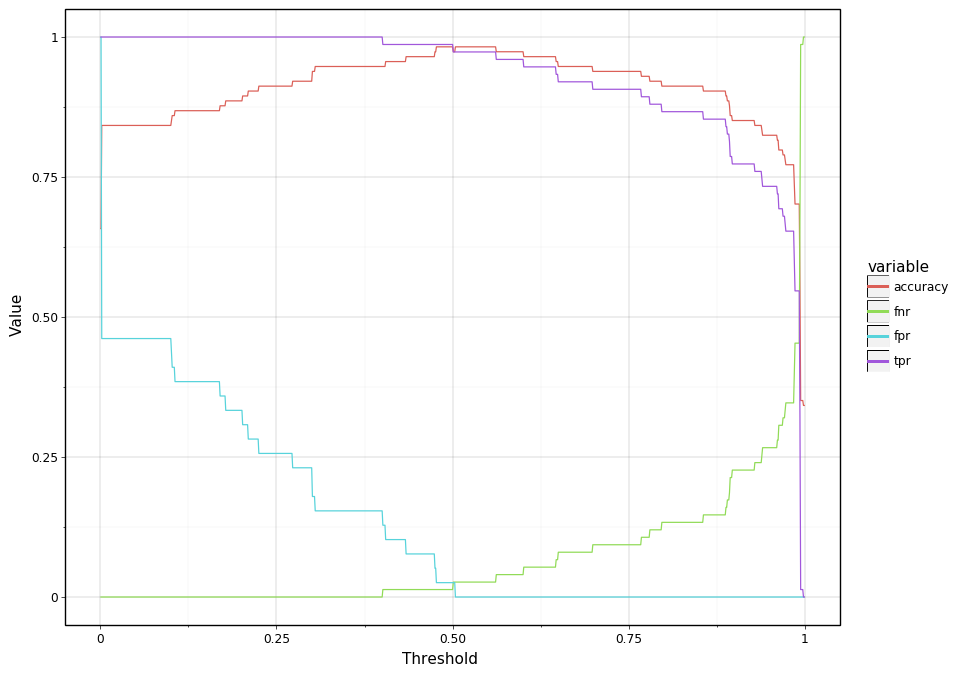

<ggplot: (-9223372029846710328)>

In [7]:
def point_estimates(df):
    """
    Computes various metrics for a given threshold value
    """
    p = float(df[df.hasCancer == 1].shape[0])
    n = float(df[df.hasCancer == 0].shape[0])
    
    def _compute(threshold):
        
        tp = df[(df.prob_1 >= threshold) & (df.hasCancer == 1)].shape[0]
        fp = df[(df.prob_1 >= threshold) & (df.hasCancer == 0)].shape[0]
        fn = df[(df.prob_1 < threshold) & (df.hasCancer == 1)].shape[0]
        t = df[
            ((df.prob_1 >= threshold) & (df.hasCancer == 1))
            | ((df.prob_1 < threshold) & (df.hasCancer == 0))
        ].shape[0]
        return (threshold, tp / p, fp / n, fn / p, t / (p + n))
    
    return _compute
    
estimator = point_estimates(test)
df = pd.DataFrame(
    [estimator(threshold/1000) for threshold in range(0, 1001, 1)],
    columns=['threshold', 'tpr', 'fpr', 'fnr', 'accuracy']
)
display(df.sample(5).sort_values('threshold'))

(
    ggplot(df.melt(id_vars='threshold'), aes(x='threshold', y='value'))
    + geom_line(aes(group='variable', colour='variable'))
    + xlab("Threshold") + ylab("Value")
    + theme_linedraw()
    + theme(figure_size=(10, 8))
)

## Area Under Curve



As discussed above, accuracy and other metrics are point estimates. This creates a problem. For instance, consider two models both have same accuracy at 0.5. But one model has a higher accuracy when $\tau = 0.25$ and another has a higher accuracy when $\tau = 0.75$. How do you decide which one is better. For a moment let's think about an ideal model. 

As shown in the below plot (grey region), one might notice that TRP and FPR curves form a closed region. Now for a momemnt think about an ideal model and how the region bounded by TPR and FPR curve will look like ? An ideal model will be one that definitively distinguishes positive and negative test cases and is accurate 100%. Thus, an ideal will be the one that assigns a probability of 1 to positive test cases and 0 for negative test cases. As a result, TPR will be always 100% irrespective what threshold value we choose. Thus, TPR will be a horizontal line intersecting y axis at 100% point. Similarly, for an ideal model FPR will be always 0% and therefore it will be a horizontal line intersecting y-axis at 0%. TPR and FPR curves for an ideal model then form the bounding box for the below shown plot. 


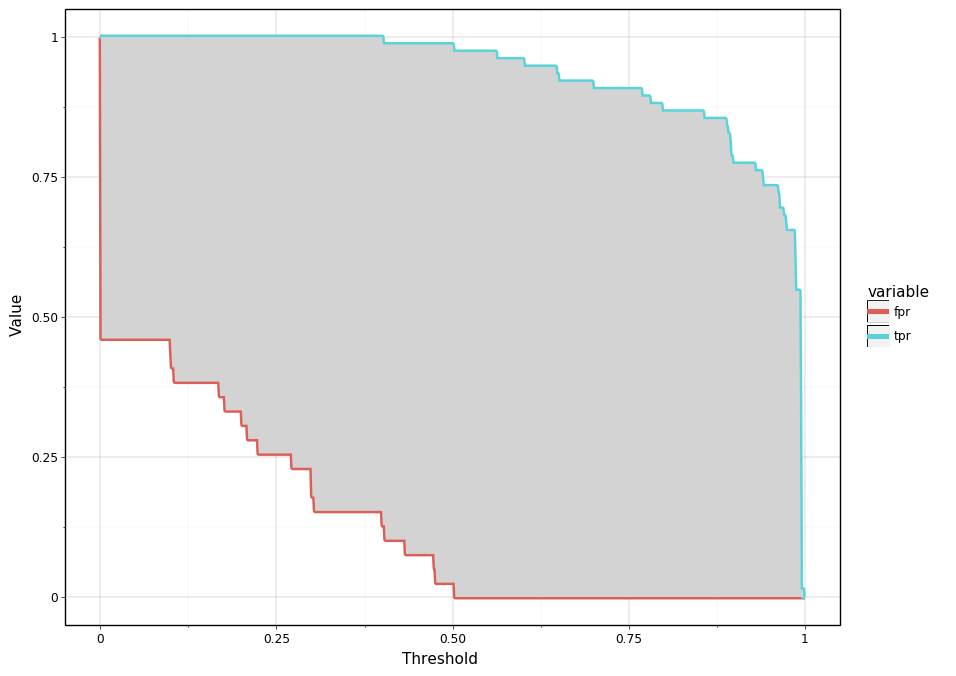

<ggplot: (7008058842)>

In [8]:
(
    ggplot()
    + geom_line(
        aes(group='variable', colour='variable', x='threshold', y='value'),
        size=2, data=df[['threshold', 'fpr', 'tpr']].melt(id_vars='threshold')
    )
    + geom_ribbon(
        aes(ymin='fpr', ymax='tpr', x='threshold'), 
        fill='lightgrey', data=df
    )
    + xlab("Threshold") + ylab("Value")
    + theme_linedraw()
    + theme(figure_size=(10, 8))
)

Based on the above discussion, it is easy to notice that as the quality of our model improves the TPR curve should move towards the top left corner and FPR should move towards the bottom right corner. In other words, the quality of our trained model improves as the area between the curves increases. This essentially forms the intution behind the Area Under Curve (AUC) metric. 

In pratice, however there is one small difference. As shown below, instead of plotting two separate curves (TPR and FPR) as a function of threshold, we can plot TPR as a function of FPR. As the model quality improves, the line will move towards top right corner and the area under the curve will increase. Similar to $R^2$ metric discussed in [chapter 1](01-RegressionMetrics.ipynb), the region above the curve (red colored region) is the opportunity area to improve our model. 

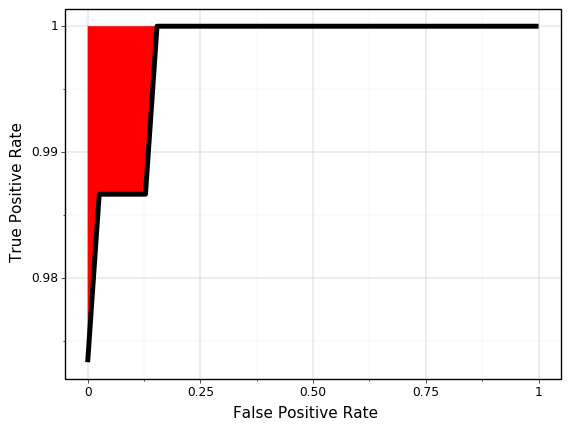

<ggplot: (7005849692)>

In [9]:
fpr_tpr_curve = df.groupby('fpr')['tpr'].max().reset_index()
(
    ggplot(
        fpr_tpr_curve,
        aes(x='fpr', y='tpr')
    ) 
#     + geom_ribbon(aes(ymax='tpr', ymin='fpr'), fill='green')
    + geom_ribbon(aes(ymin='tpr', ymax=1), fill='red') 
    + geom_line(size=2)
    + xlab("False Positive Rate")
    + ylab("True Positive Rate")
    + theme_linedraw()
)

Below code snippet computes the area under curve and validates that this what we get from sklearn. 

In [10]:
from sklearn.metrics import roc_auc_score
auc_manually = np.trapz(fpr_tpr_curve['tpr'], x=fpr_tpr_curve['fpr'])
auc_sklearn = roc_auc_score(test['hasCancer'], test['prob_1'])

print("Area Under Curve (manually): {:.3}".format(auc_manually))
print("Area Under Curve (Sklearn): {:.3}".format(auc_sklearn))


NameError: name 'np' is not defined

## $F_1$ and Variants

Another popular metric that is often used to evaluate classifiers is $F_1$ score and it's variant. $F_1$ is described as the harmonic mean of precision and recall. To better understand the definition, first let's try to understand what is precision and recall. 

Often when dealing with a classification problem, we are interested in the positive cases and how well the trained model is able to detect these positive test cases. In other words we are interested in true positives (TP). However, the number of TP by themself doesn't make sense. For instance, saying there are 50 TP doesn't communicate any insightful information. In order to evaluate the quality of the model in reference to true positives, we need to normalize the number of true positive cases with the number of positive cases. For instance, it makes more sense if one says that the model is able to detect 50 of 200 positive cases or true positive rate is 25% of actual positive cases.

There is a however another challenge. We can talk about the total number of positive cases, used for normalizing true positiives, from two different perspectives: from the data perspective or from the model perspective. From the data perspective, the total number of positives cases is the number of cases that are actually labeled as positives. Based on the confusion matrix, the total number of positive cases from the data perspective is the summation of true positives (TP) and false negatives (FN). **True positive rate from the data perspecrtive is known as "recall"**. Mathematically, it can be represented as:

$$ Recall = \frac{TP}{TP + FN}$$

In contrast to recall, **precision is true positive rate from the model perspective**. The total number of positive cases is the number of cases that the model predicts to be positive. Based on the confusion matrix, it can be represented as:

$$ Precision = \frac{TP}{TP + FP} $$

Notice that in the formula for recall and precision only the denomoniator is different. One is the total number of actual positive cases in the test dataset and another is the total number of predicted positive cases, respectively. 

Now we have two different ways to talk about true positive rates. However as a metric it we would like to have a single number. One simple way to combine these two different true positive rates is to take the average. When dealing with ratio, harmonic mean makes more sense than arithmetic mean. This harmonic mean of precision and recall is termed as $F_1$ score and written as:

$$ F_1 = \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}} = \frac{2 \times Precision \times Recall}{Precsiion + Recall } $$

